In [2]:
# Loading Libraries
library(ArchR)
library(dplyr)
library(Seurat)

In [3]:
# _____________________________________________
# ---------------- Gene Scores ----------------
# _____________________________________________

# navigate to PBMC project with filtered doublets
PATH_TO_DATA       <- "../data" # /Users/nrank/Desktop/BioInf/IntegratedProject/TrainedMOFA_ArchR/
FILENAME_ARROWFILE <- "../data/10k_sorted.arrow"
FILENAME_SEURAT    <- "../data/sorted_10k_seurat.rds" 

#setwd(PATH_TO_DATA)

In [ ]:
# get GeneScoreMatrix summarised experiment
gsm_se   <- getMatrixFromArrow(FILENAME_ARROWFILE, 'GeneScoreMatrix')
gsm      <- assays(gsm_se)[['GeneScoreMatrix']]

row_data <- rowData(gsm_se)
genes    <-  row_data["name"]
gsm_df   <- as.data.frame(as.matrix(gsm))
row.names(gsm_df) <- genes$name

# remove heading from colnames
# colnames(gsm_df) <- substring(colnames(gsm_df), 11, 30)
colnames(gsm_df) <- substring(colnames(gsm_df), nchar(colnames(gsm_df))-18+1, nchar(colnames(gsm_df)))

In [5]:
# _____________________________________________
# ---------- GEX ------------
# _____________________________________________

# Load the PBMC dataset
seurat_obj <- readRDS(file = FILENAME_SEURAT)

data_matrix = GetAssayData(object=seurat_obj, assay="RNA", slot="data")
gex_df = as.data.frame(data_matrix)

Loading required package: Signac

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [6]:
# _____________________________________________
# --- Ordering and Filtering ---
# _____________________________________________
# check which genes are in both datasets
gsm_df_rn <- rownames(gsm_df)
gex_df_rn <- rownames(gex_df)

#intersect(gex_df_rn,gsm_df_rn) %>% length # number of genes that are in both datasets
#setdiff(gsm_df_rn, intersect(gex_df_rn,gsm_df_rn)) %>% length
#setdiff(gex_df_rn, intersect(gex_df_rn,gsm_df_rn))

# keep only rows and cells that are in the intersect 
rows.to.keep_gex<-which(rownames(gex_df) %in% intersect(gex_df_rn,gsm_df_rn))
rows.to.keep_gsm<-which(rownames(gsm_df) %in% intersect(gex_df_rn,gsm_df_rn))

# all genes that left over after the first intersect (isoforms, etc.)
# left.rownames.gex <- gex_df[-rows.to.keep_gex, ] %>% rownames() # NEW
# left.rownames.gsm <- gsm_df[-rows.to.keep_gsm, ] %>% rownames() # NEW
# gex_df_left <- gex_df[-rows.to.keep_gex, ]
# gsm_df_left <- gsm_df[-rows.to.keep_gsm, ]
# gex_df_left <-  gex_df_left[order(row.names(gex_df_left)), ]
# gsm_df_left <-  gsm_df_left[order(row.names(gsm_df_left)), ]


# genes that are orignially in the intersect of GEX, ATAQ
gex_df <- gex_df[rows.to.keep_gex, intersect(colnames(gex_df), colnames(gsm_df))]
gsm_df <- gsm_df[rows.to.keep_gsm, intersect(colnames(gex_df), colnames(gsm_df))]

# order rows and columns in increasing order
gex_df <-  gex_df[, order(names(gex_df))]
gex_df <-  gex_df[order(row.names(gex_df)), ]
gsm_df <-  gsm_df[, order(names(gsm_df))]
gsm_df <-  gsm_df[order(row.names(gsm_df)), ]

In [7]:
# check correlation between ranks of genes - all genes
# taus <- c()
# 
# for (cn in c(1:ncol(gsm_df))){
#   print(cn)
#   a <- cor.test(gsm_df[, cn], gex_df[, cn], method='kendall')
#   tau <- a$estimate[[1]]
#   taus <- c(taus, tau)
# }
# 
# hist(taus)
# saveRDS(taus, 'taus_3k_sorted.rds')

#a <- cor.test(gsm_df[, 1], gex_df[, 1], method='kendall')
#a$estimate[[1]]
#cor.test(x, y, method = "spearman") in its "stats" package (also cor(x, y, method = "spearman") will work


# check correlation between ranks of genes -  upper 15% of the genes
# comparison of upper 15% ranks
taus_allCells <- c()
common_prop_allCells <- c()

for (cell in c(1:ncol(gsm_df))){
# order genes by count/score per cell
#cell <-  1
gsm_allCells <- gsm_df
gex_allCells <- gex_df

gsm_allCells$rown <- rownames(gsm_allCells)
gex_allCells$rown <- rownames(gex_allCells)

gsm_cell <- gsm_allCells %>% select(c(cell, 'rown'))
gex_cell <- gex_allCells %>% select(c(cell, 'rown'))

cellId <- colnames(gsm_cell)[1]
colnames(gsm_cell) <- c('cellID', 'rown')
colnames(gex_cell) <- c('cellID', 'rown')
gsm_cell <- gsm_cell %>% arrange(desc(cellID))
gex_cell <- gex_cell %>% arrange(desc(cellID))

# cut off the first 15 %
gsm_cell_cut <- gsm_cell[1:round(nrow(gsm_cell)*0.15), ]
gex_cell_cut <- gex_cell[1:round(nrow(gex_cell)*0.15), ]


intersect(gsm_cell_cut$rown, gex_cell_cut$rown)

gsm_cell_int <- gsm_cell_cut %>% filter(rown %in% intersect(gsm_cell_cut$rown, gex_cell_cut$rown))
gex_cell_int <- gex_cell_cut %>% filter(rown %in% intersect(gsm_cell_cut$rown, gex_cell_cut$rown))
gsm_cell_int <-  gsm_cell_int[order(row.names(gsm_cell_int)), ]
gex_cell_int <-  gex_cell_int[order(row.names(gex_cell_int)), ]

common_prop <- length(intersect(gsm_cell_cut$rown, gex_cell_cut$rown))/nrow(gsm_cell_cut)
tau_cell <- cor.test(gsm_cell_int[, 'cellID'], gex_cell_int[, 'cellID'], method='kendall')
tau_cell <- tau_cell$estimate[[1]]
taus_allCells <- c(taus_allCells, tau_cell)
common_prop_allCells <- c(common_prop_allCells, common_prop)
}

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(cell)` instead of `cell` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



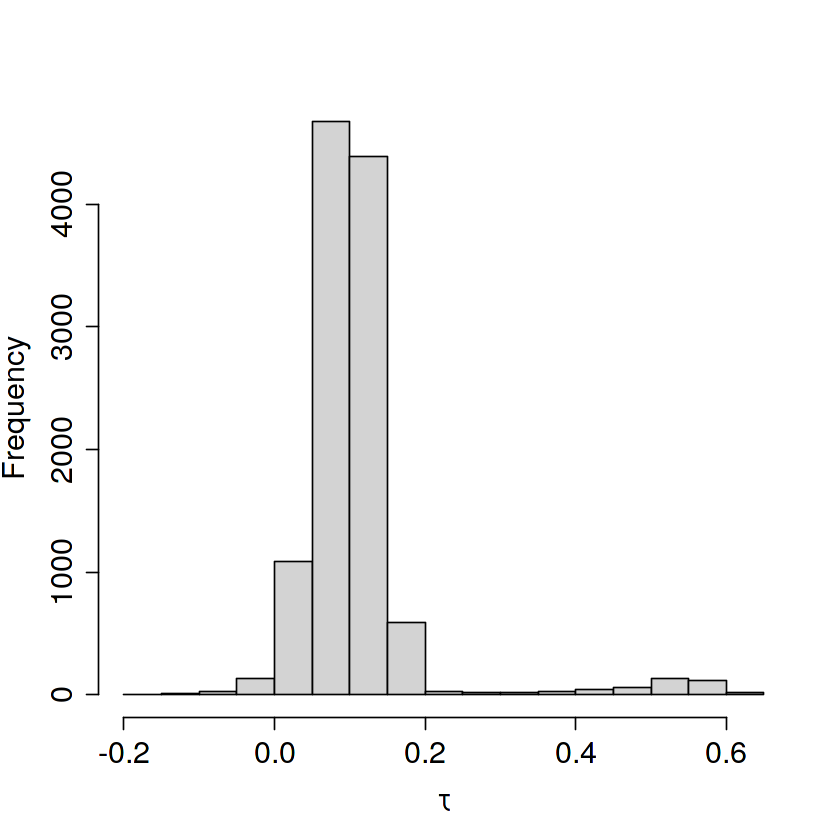

sd_taus:  0.08680362mean_taus:  0.1091857sd_common_prop:  0.05300262mean_common_prop:  0.2429018

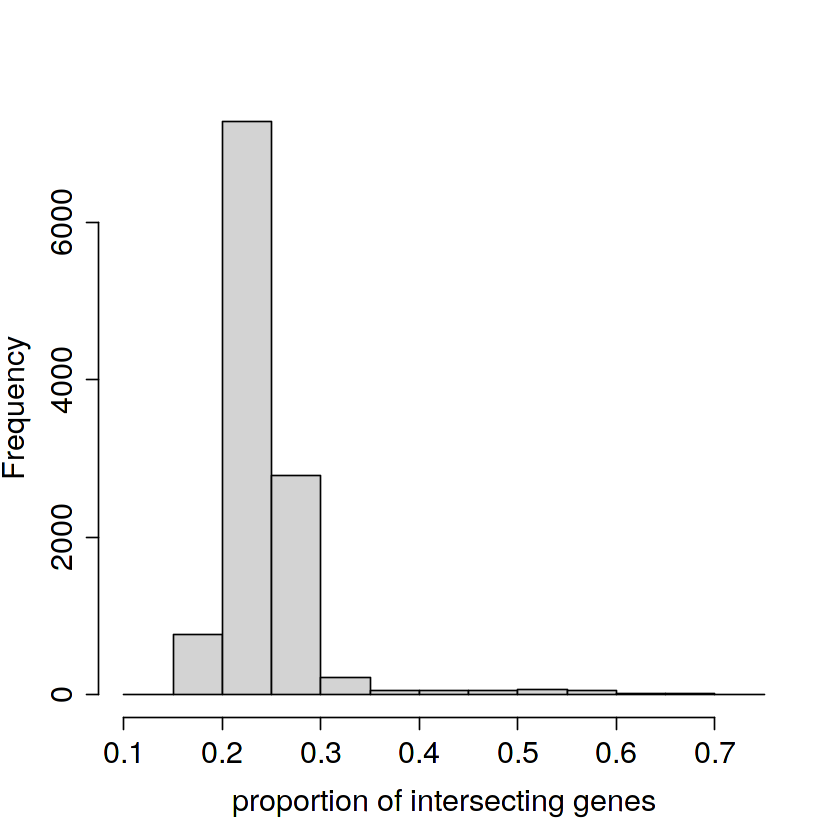

In [11]:

par(mfrow=c(1,1))
hist(taus_allCells, main = "", xlab = expression(tau), cex.lab=1.5, cex.axis=1.5, cex.sub=1.5)

par(mfrow=c(1,1))
hist(common_prop_allCells, main = " ", xlab = 'proportion of intersecting genes', cex.lab=1.5, cex.axis=1.5, cex.sub=1.5)


sd_taus <- sd(taus_allCells)
sd_common_prop <- sd(common_prop_allCells)
mean_taus <- mean(taus_allCells)
mean_common_prop <- mean(common_prop_allCells)
cat('sd_taus: ', sd_taus)
cat('mean_taus: ', mean_taus)
cat('sd_common_prop: ', sd_common_prop)
cat('mean_common_prop: ', mean_common_prop)